In [1]:
from pzflow import Flow, FlowEnsemble
from pzflow.bijectors import Chain, ShiftBounds, RollingSplineCoupling
from pzflow.distributions import Uniform

import jax.numpy as jnp
import matplotlib.pyplot as plt
import tables_io
import pandas as pd
import numpy as np
import h5py
import optax

from rail.creation.degradation import LSSTErrorModel

In [2]:
plt.rcParams["figure.facecolor"] = "white"

# Train a flow to look like application data

## Read in application data

In [3]:
dc2_file = 'augmentation_paper_plots/catalogs/fzboost_application_catalog.hdf5'
dc2_data = tables_io.read(dc2_file)
dc2_data = pd.DataFrame(dc2_data['photometry'])
dc2_data

,eg,egr,ei,eiz,er,eri,eu,eug,ey,ez,...,iz,r,ri,size,specz,u,ug,y,z,zy
0,0.265709,0.294343,0.065172,0.221899,0.126635,0.142422,0.596857,0.653329,0.296248,0.212113,...,0.400972,24.05779,0.726830,1.37057,0.589002,25.02543,-0.402275,22.99856,22.92999,-0.068571
1,0.076845,0.095560,0.026741,0.051276,0.056803,0.062783,0.256366,0.267635,0.071431,0.043750,...,0.686113,22.93367,0.846581,2.12694,0.999547,23.74729,0.175136,21.22587,21.40098,0.175107
2,0.180536,0.187415,0.046138,0.106715,0.050309,0.068263,2.177670,2.185140,0.126338,0.096225,...,0.388178,23.32877,0.704033,1.34182,0.387335,26.68006,1.779700,22.12131,22.23655,0.115246
3,0.331025,0.431263,0.151683,0.344966,0.276424,0.315306,8.473580,8.480050,1.084460,0.309829,...,0.430022,24.62058,0.621974,3.19779,1.715034,27.38192,2.240830,24.05406,23.56858,-0.485481
4,0.289616,0.399928,0.059403,0.208866,0.275799,0.282123,0.269342,0.395503,0.411137,0.200241,...,0.074200,24.65532,1.200760,1.38811,0.824784,24.74905,-0.494577,23.32166,23.38036,0.058706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5520453,0.028926,0.042626,0.064517,0.177220,0.031310,0.071713,0.102205,0.106220,0.717934,0.165060,...,-0.104704,24.20727,-0.149967,1.84581,2.290370,24.72785,0.382242,25.36828,24.46194,-0.906345
5520454,0.140034,0.172357,0.119872,0.334889,0.100486,0.156418,0.497563,0.516893,0.591785,0.312700,...,-0.044257,25.88642,0.414821,1.09283,0.640610,26.64029,0.230445,25.32067,25.51585,0.195186
5520455,0.048102,0.072631,0.089373,0.163732,0.054419,0.104637,0.121744,0.130903,0.461739,0.137188,...,0.478558,25.26098,0.120627,1.04954,1.371529,25.13690,-0.190757,25.04124,24.66180,-0.379440
5520456,0.032535,0.045226,0.044211,0.080984,0.031415,0.054236,0.079361,0.085771,0.128423,0.067851,...,0.544235,24.50432,0.249666,1.48199,1.063150,24.51700,-0.220228,23.49994,23.71041,0.210471


In [4]:
headers = ['i', 'ug', 'gr', 'ri', 'iz', 'zy', 'ei', 'eug', 'egr', 'eri', 'eiz', 'ezy']
dc2_data = dc2_data[headers]
dc2_data

,i,ug,gr,ri,iz,zy,ei,eug,egr,eri,eiz,ezy
0,23.33096,-0.402275,1.369910,0.726830,0.400972,-0.068571,0.065172,0.653329,0.294343,0.142422,0.221899,0.364355
1,22.08709,0.175136,0.638481,0.846581,0.686113,0.175107,0.026741,0.267635,0.095560,0.062783,0.051276,0.083765
2,22.62473,1.779700,1.571600,0.704033,0.388178,0.115246,0.046138,2.185140,0.187415,0.068263,0.106715,0.158809
3,23.99861,2.240830,0.520519,0.621974,0.430022,-0.485481,0.151683,8.480050,0.431263,0.315306,0.344966,1.127850
4,23.45456,-0.494577,0.588305,1.200760,0.074200,0.058706,0.059403,0.395503,0.399928,0.282123,0.208866,0.457308
...,...,...,...,...,...,...,...,...,...,...,...,...
5520453,24.35723,0.382242,0.138345,-0.149967,-0.104704,-0.906345,0.064517,0.106220,0.042626,0.071713,0.177220,0.736664
5520454,25.47160,0.230445,0.523430,0.414821,-0.044257,0.195186,0.119872,0.516893,0.172357,0.156418,0.334889,0.669321
5520455,25.14036,-0.190757,0.066669,0.120627,0.478558,-0.379440,0.089373,0.130903,0.072631,0.104637,0.163732,0.481688
5520456,24.25465,-0.220228,0.232908,0.249666,0.544235,0.210471,0.044211,0.085771,0.045226,0.054236,0.080984,0.145245


## select random subsample for faster compute time

In [5]:
gal_inds = dc2_data.index.values.tolist()
selected_gals = np.random.choice(gal_inds, 500000, replace=False)

In [6]:
dc2_data = dc2_data.loc[np.sort(selected_gals)]
dc2_data

,i,ug,gr,ri,iz,zy,ei,eug,egr,eri,eiz,ezy
0,23.33096,-0.402275,1.369910,0.726830,0.400972,-0.068571,0.065172,0.653329,0.294343,0.142422,0.221899,0.364355
8,24.49013,0.571021,-0.813827,1.616800,0.306922,-3.854550,0.162374,1.514520,0.712631,0.685699,0.417900,32.361500
18,23.40197,-0.845896,1.934090,0.602243,0.395515,0.516051,0.062168,0.959144,0.861735,0.100345,0.142082,0.234836
35,21.57001,0.168536,0.363277,0.762876,0.083271,0.597978,0.015610,0.088640,0.044505,0.027967,0.044134,0.084393
40,23.00997,0.077948,0.828960,0.874365,-0.028170,0.117337,0.056096,0.358564,0.159114,0.093079,0.191428,0.334057
...,...,...,...,...,...,...,...,...,...,...,...,...
5520425,23.11564,0.857798,0.886588,0.749500,0.345720,0.087662,0.022595,0.341491,0.060066,0.036413,0.044108,0.079515
5520430,24.23053,0.629379,0.916638,0.750324,0.833114,0.638335,0.043213,0.521365,0.110991,0.068111,0.065730,0.080408
5520432,24.97136,-0.717337,1.709300,0.986593,0.752571,-0.168022,0.081060,0.806010,0.448193,0.137914,0.130980,0.294330
5520447,24.61096,-0.144356,-0.088122,0.268382,0.311596,-0.473452,0.059713,0.090067,0.051325,0.072176,0.120221,0.399464


## build bijector and latent space for flow

In [8]:
#build bijector and latent space
# get minima and maxima for each column
mins = jnp.array(dc2_data.min(axis=0))
maxs = jnp.array(dc2_data.max(axis=0))

# get the number of dimensions
ndim = dc2_data.shape[1]

# build the bijector
bijector = Chain(
    ShiftBounds(mins, maxs, B=4),
    RollingSplineCoupling(ndim, B=5),
)

latent = Uniform(input_dim=ndim, B=5)

In [5]:
#columns = ['i', 'ug', 'gr', 'ri', 'iz', 'zy']
#dc2_flow = Flow(dc2_data.columns, bijector=bijector, latent=latent)
dc2_flow = Flow(file="augmentation_paper_plots/flows/dc2_flow.pzflow.pkl")

## flow!

In [10]:
%%time
losses = dc2_flow.train(dc2_data, epochs=100, verbose=True)

Training 100 epochs 
Loss:
(0) inf
(1) inf
Training stopping after epoch 1 because training loss diverged.
CPU times: user 1min 5s, sys: 5.23 s, total: 1min 10s
Wall time: 54.9 s


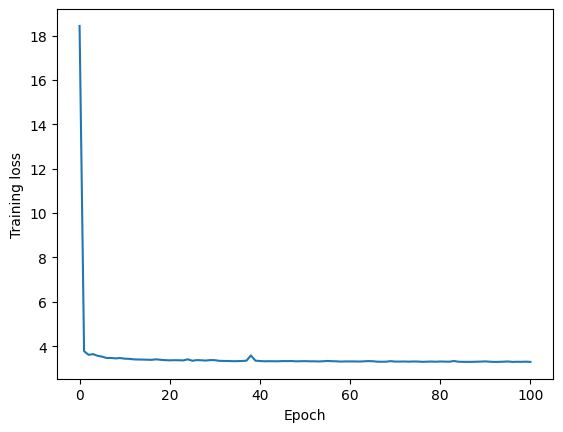

In [9]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Training loss")
plt.show()

In [10]:
dc2_flow.save("augmentation_paper_plots/flows/dc2_flow_100epochs.pzflow.pkl")

## check it looks like application data

In [6]:
samples = dc2_flow.sample(10000, seed=0)

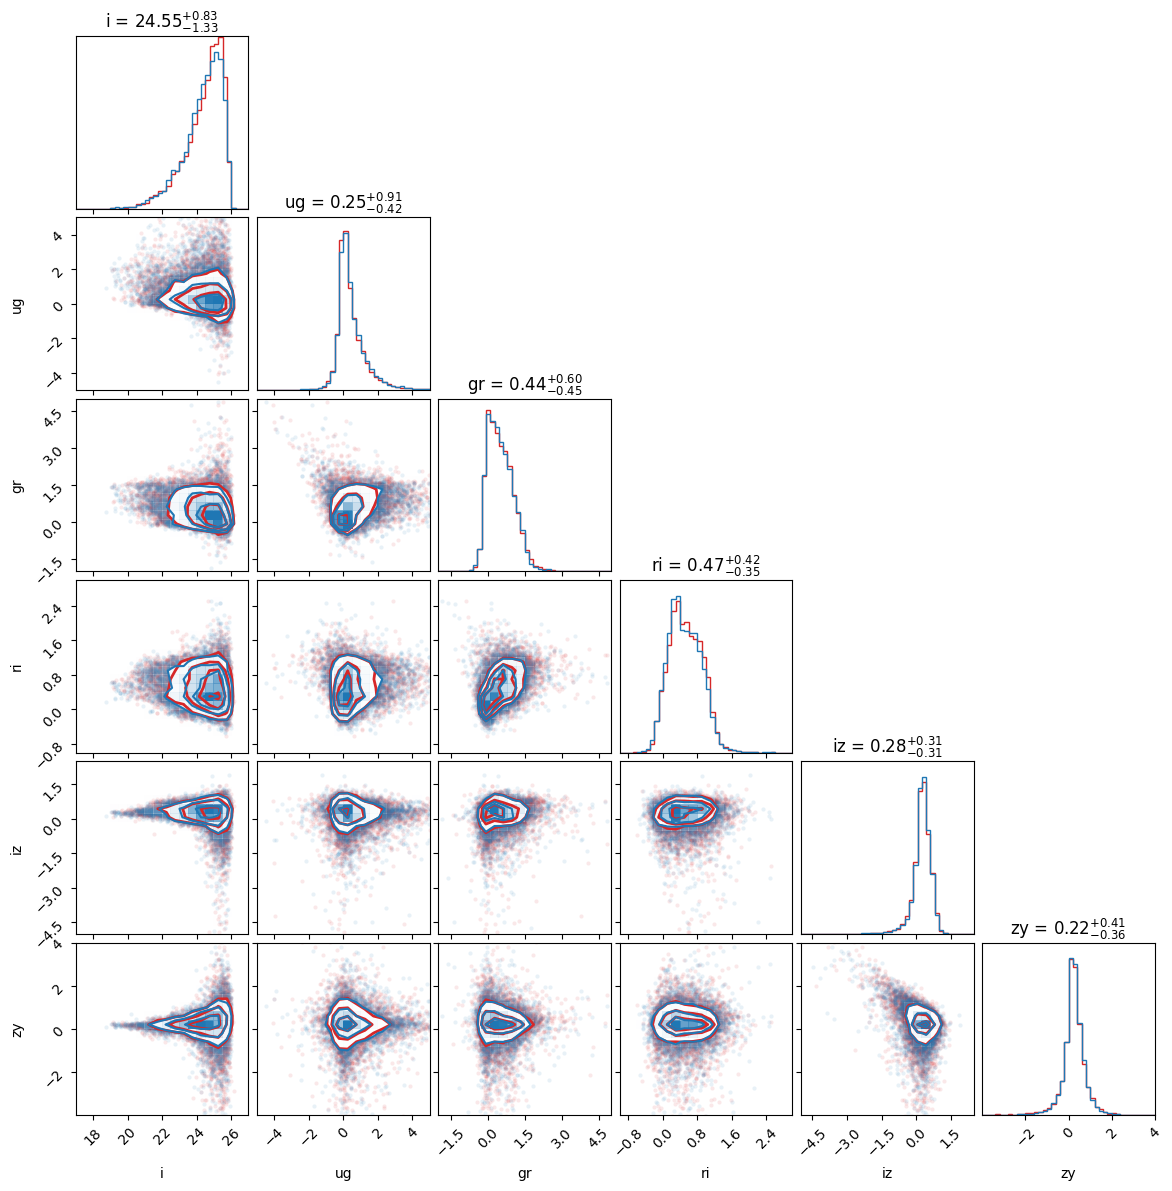

In [7]:
import corner
fig = plt.figure(figsize=(12,12))

ranges = [(17,27), (-5,5), (-2,5), (-1,3), (-5,2.5), (-4,4)]

corner.corner(samples, fig=fig, color='C3', bins=20, range=ranges, hist_bin_factor=2, data_kwargs={'ms':3}, contour_kwargs={'linewidths':2})

corner.corner(dc2_data[:10000], fig=fig, bins=20, range=ranges, hist_bin_factor=2, color='C0', data_kwargs={'ms':3}, show_titles=True, labels=dc2_data.columns);

# Train a Conditional Buzzard Flow

## read in Buzzard data and do some cleaning

In [4]:
buz_file = 'augmentation_paper_plots/catalogs/buzzard_shifted_mags.hdf5'
buz_data = tables_io.read(buz_file)
buz_data = pd.DataFrame(buz_data['photometry'])
buz_data

,eg,egr,ei,eiz,er,eri,eu,eug,ey,ez,...,i,iz,r,ri,specz,u,ug,y,z,zy
0,0.011773,0.013997,0.004830,0.007974,0.007572,0.008981,0.054568,0.055823,0.011582,0.006345,...,23.408878,0.341970,24.227561,0.818683,0.675341,25.098682,0.339599,22.762164,23.066908,0.304744
1,0.037506,0.052931,0.028096,0.043802,0.037349,0.046737,0.110666,0.116849,0.065846,0.033604,...,25.320573,0.443722,25.960300,0.639727,0.912532,25.866379,-0.150758,24.649076,24.876851,0.227775
2,0.002951,0.003132,0.000719,0.001130,0.001050,0.001273,0.051192,0.051277,0.001616,0.000872,...,21.341123,0.429319,22.082980,0.741856,0.459211,25.029352,1.772542,20.624115,20.911805,0.287690
3,0.007353,0.009330,0.004210,0.007083,0.005743,0.007120,0.025386,0.026429,0.010443,0.005697,...,23.259617,0.309675,23.927357,0.667740,0.624410,24.267813,0.019698,22.649775,22.949941,0.300166
4,0.004829,0.005557,0.002478,0.004227,0.002749,0.003701,0.025440,0.025895,0.006342,0.003425,...,22.684268,0.286741,23.127437,0.443169,0.504495,24.270144,0.478597,22.108387,22.397527,0.289140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4735951,0.023925,0.027308,0.012816,0.021688,0.013164,0.018372,0.125893,0.128146,0.030799,0.017496,...,24.468344,0.300107,24.828082,0.359739,0.433763,26.006341,0.477308,23.824100,24.168236,0.344136
4735952,0.002238,0.002862,0.001789,0.003108,0.001784,0.002526,0.018811,0.018944,0.005046,0.002541,...,22.330488,0.257044,22.658071,0.327584,0.118358,23.942367,0.985838,21.860116,22.073443,0.213327
4735953,0.019542,0.026671,0.011932,0.017901,0.018151,0.021722,0.050052,0.053731,0.026456,0.013344,...,24.390723,0.516620,25.176857,0.786134,0.837266,25.004893,-0.304400,23.659065,23.874103,0.215038
4735954,0.016259,0.019299,0.011495,0.020523,0.010397,0.015499,0.070370,0.072224,0.030955,0.017002,...,24.350225,0.213104,24.571879,0.221654,0.428085,25.374814,0.265207,23.829588,24.137121,0.307533


In [5]:
headers = ['specz', 'i', 'ug', 'gr', 'ri', 'iz', 'zy']
mask = (buz_data['u']<30) & (buz_data['g']<30) & (buz_data['r']<30) & (buz_data['i']<30) & (buz_data['z']<30) & (buz_data['y'] < 30)
buz_data = buz_data[mask]
buz_data = buz_data[headers]
buz_data

,specz,i,ug,gr,ri,iz,zy
0,0.675341,23.408878,0.339599,0.531523,0.818683,0.341970,0.304744
1,0.912532,25.320573,-0.150758,0.056837,0.639727,0.443722,0.227775
2,0.459211,21.341123,1.772542,1.173830,0.741856,0.429319,0.287690
3,0.624410,23.259617,0.019698,0.320758,0.667740,0.309675,0.300166
4,0.504495,22.684268,0.478597,0.664110,0.443169,0.286741,0.289140
...,...,...,...,...,...,...,...
4735951,0.433763,24.468344,0.477308,0.700951,0.359739,0.300107,0.344136
4735952,0.118358,22.330488,0.985838,0.298457,0.327584,0.257044,0.213327
4735953,0.837266,24.390723,-0.304400,0.132435,0.786134,0.516620,0.215038
4735954,0.428085,24.350225,0.265207,0.537728,0.221654,0.213104,0.307533


## select subsample for faster compute time

In [6]:
gal_inds = buz_data.index.values.tolist()
selected_gals = np.random.choice(gal_inds, 200000, replace=False)

In [7]:
buz_data = buz_data.loc[np.sort(selected_gals)]
buz_data

,specz,i,ug,gr,ri,iz,zy
7,0.630760,22.211019,-0.012190,0.493374,0.688420,0.282789,0.301494
32,0.586640,25.899926,0.158142,0.344479,0.376571,0.130919,0.179132
55,0.158632,26.179643,0.140190,-0.138106,0.091222,0.021179,0.114848
126,0.392973,21.850200,1.208037,1.048721,0.536581,0.403625,0.269012
141,0.857419,25.003501,0.059537,0.350710,0.856743,0.436810,0.192976
...,...,...,...,...,...,...,...
4735877,0.304647,26.253045,-0.141795,-0.095871,-0.092026,0.353501,-0.196108
4735891,0.492836,22.345584,1.791006,1.182910,0.769201,0.433911,0.316276
4735914,0.422788,22.767975,2.133258,1.229308,0.656450,0.416969,0.274357
4735926,0.422389,24.429193,0.503483,0.650693,0.264887,0.245229,0.296777


## Flow!

In [8]:
buz_flow = Flow(data_columns=["specz"], conditional_columns=['i', 'ug', 'gr', 'ri', 'iz', 'zy'])
#buz_flow = Flow(file="augmentation_paper_plots/flows/buzzard_conditional_flow_150epochs.pzflow.pkl")

In [9]:
%%time
opt = optax.adam(1e-5)
losses = buz_flow.train(buz_data, epochs=150, optimizer=opt, verbose=True)

Training 150 epochs 
Loss:
(0) 1.0675
(1) 0.8885
(8) -0.2012
(15) -0.9716
(22) -1.3620
(29) -1.5954
(36) -1.7574
(43) -1.8819
(50) -1.9986
(57) -2.0827
(64) -2.1612
(71) -2.2197
(78) -2.2699
(85) -2.3125
(92) -2.3509
(99) -2.3815
(106) -2.4124
(113) -2.4372
(120) -2.4615
(127) -2.4823
(134) -2.5027
(141) -2.5199
(148) -2.5372
(150) -2.5404
CPU times: user 3min, sys: 40.5 s, total: 3min 41s
Wall time: 1min 52s


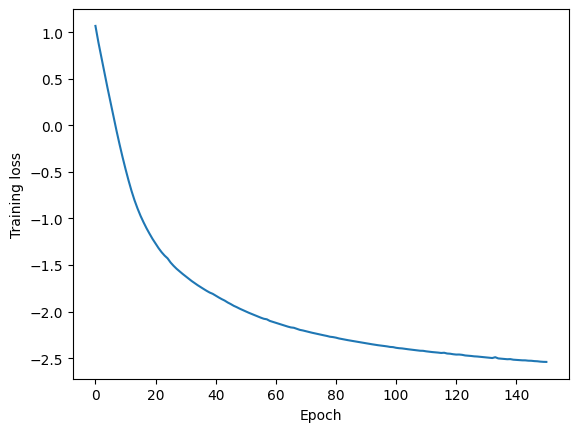

In [10]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Training loss")
plt.show()

## check it works

In [13]:
conds = ['i', 'ug', 'gr', 'ri', 'iz', 'zy']
samples = buz_flow.sample(10000, conditions=buz_data[conds][:1], seed=0)
samples

,i,ug,gr,ri,iz,zy
0,22.308062,0.621648,0.855948,0.946151,0.423512,0.130645
1,21.858906,0.712394,0.902202,0.833263,0.512770,0.178425
2,23.208723,0.362300,0.908553,0.280831,0.062367,0.361748
3,21.446123,0.753764,0.995525,0.578986,0.171095,0.213830
4,23.665415,0.939116,0.344145,0.235740,0.014317,0.062404
...,...,...,...,...,...,...
9995,22.423365,0.243964,0.737895,0.405151,0.120858,0.228119
9996,21.402998,0.933228,1.117727,0.380766,0.399159,0.127015
9997,20.565989,2.260441,1.590524,0.665099,0.347227,0.198702
9998,22.228584,0.838919,0.836490,0.868056,0.271196,0.192989


In [11]:
buz_flow.save("augmentation_paper_plots/flows/buzzard_shiftedmags_conditional_flow_150epochs.pzflow.pkl")

# Sample photometry from DC2, sample redshift from Buzzard

## generate photometry

In [12]:
#read in DC2 flow
dc2_flow = Flow(file="augmentation_paper_plots/flows/dc2_flow_100epochs.pzflow.pkl")
buz_flow = Flow(file="augmentation_paper_plots/flows/buzzard_shiftedmags_conditional_flow_150epochs.pzflow.pkl")

In [13]:
#generate some photometry samples
photometry = dc2_flow.sample(1000000, seed=0)
photometry

,i,ug,gr,ri,iz,zy
0,25.337305,-0.918268,0.402000,1.255322,0.760064,0.277505
1,24.058702,-0.181257,1.015048,1.079190,0.320415,0.109133
2,24.644035,1.276435,0.661224,0.739126,-0.084380,0.252039
3,22.849552,0.199299,0.393654,0.583667,0.082778,-0.048988
4,23.465757,0.724361,0.341958,0.347879,-0.016554,-0.490713
...,...,...,...,...,...,...
999995,25.559334,0.294782,-0.068759,0.565966,-0.283485,-0.101731
999996,24.391462,0.370443,0.358716,0.814088,0.444732,0.818379
999997,25.285122,0.946484,0.707821,0.725162,0.385664,0.530931
999998,24.907513,-0.212360,0.219984,0.869919,0.497561,-0.478011


In [14]:
keys = list(photometry.keys())
for key in keys:
    nans = np.argwhere(np.isnan(photometry[key].to_numpy()))
    print(key, nans.shape[0])

i 0
ug 0
gr 0
ri 0
iz 0
zy 0


## generate redshifts for the photometry

In [15]:
#generate redshifts
conds = ['i', 'ug', 'gr', 'ri', 'iz', 'zy']
samples = buz_flow.sample(nsamples=1, conditions=photometry, seed=0)
samples

,specz,i,ug,gr,ri,iz,zy
0,0.867955,25.337305,-0.918268,0.402000,1.255322,0.760064,0.277505
1,0.793092,24.058702,-0.181257,1.015048,1.079190,0.320415,0.109133
2,0.737080,24.644035,1.276435,0.661224,0.739126,-0.084380,0.252039
3,0.807872,22.849552,0.199299,0.393654,0.583667,0.082778,-0.048988
4,0.394589,23.465757,0.724361,0.341958,0.347879,-0.016554,-0.490713
...,...,...,...,...,...,...,...
999995,0.273966,25.559334,0.294782,-0.068759,0.565966,-0.283485,-0.101731
999996,0.585277,24.391462,0.370443,0.358716,0.814088,0.444732,0.818379
999997,0.533783,25.285122,0.946484,0.707821,0.725162,0.385664,0.530931
999998,0.827968,24.907513,-0.212360,0.219984,0.869919,0.497561,-0.478011


In [16]:
nan_locs = np.where(np.isnan(samples['specz'].to_numpy()))
samples.drop(labels=nan_locs[0], inplace=True)
samples

,specz,i,ug,gr,ri,iz,zy
0,0.867955,25.337305,-0.918268,0.402000,1.255322,0.760064,0.277505
1,0.793092,24.058702,-0.181257,1.015048,1.079190,0.320415,0.109133
2,0.737080,24.644035,1.276435,0.661224,0.739126,-0.084380,0.252039
3,0.807872,22.849552,0.199299,0.393654,0.583667,0.082778,-0.048988
4,0.394589,23.465757,0.724361,0.341958,0.347879,-0.016554,-0.490713
...,...,...,...,...,...,...,...
999995,0.273966,25.559334,0.294782,-0.068759,0.565966,-0.283485,-0.101731
999996,0.585277,24.391462,0.370443,0.358716,0.814088,0.444732,0.818379
999997,0.533783,25.285122,0.946484,0.707821,0.725162,0.385664,0.530931
999998,0.827968,24.907513,-0.212360,0.219984,0.869919,0.497561,-0.478011


In [17]:
keys = list(samples.keys())
for key in keys:
    nans = np.argwhere(np.isnan(samples[key].to_numpy()))
    print(key, nans.shape[0])

specz 0
i 0
ug 0
gr 0
ri 0
iz 0
zy 0


## Expand out photometry, save file

In [18]:
r = samples['ri'] + samples['i']
g = samples['gr'] + r
u = samples['ug'] + g
z = samples['i'] - samples['iz']
y = z - samples['zy']

In [19]:
samples['r'] = r
samples['g'] = g
samples['u'] = u
samples['z'] = z
samples['y'] = y

In [20]:
samples

,specz,i,ug,gr,ri,iz,zy,r,g,u,z,y
0,0.867955,25.337305,-0.918268,0.402000,1.255322,0.760064,0.277505,26.592627,26.994627,26.076359,24.577242,24.299738
1,0.793092,24.058702,-0.181257,1.015048,1.079190,0.320415,0.109133,25.137892,26.152939,25.971682,23.738287,23.629154
2,0.737080,24.644035,1.276435,0.661224,0.739126,-0.084380,0.252039,25.383162,26.044386,27.320820,24.728415,24.476376
3,0.807872,22.849552,0.199299,0.393654,0.583667,0.082778,-0.048988,23.433218,23.826872,24.026171,22.766773,22.815762
4,0.394589,23.465757,0.724361,0.341958,0.347879,-0.016554,-0.490713,23.813637,24.155594,24.879955,23.482311,23.973024
...,...,...,...,...,...,...,...,...,...,...,...,...
999995,0.273966,25.559334,0.294782,-0.068759,0.565966,-0.283485,-0.101731,26.125299,26.056540,26.351322,25.842819,25.944551
999996,0.585277,24.391462,0.370443,0.358716,0.814088,0.444732,0.818379,25.205549,25.564264,25.934708,23.946730,23.128351
999997,0.533783,25.285122,0.946484,0.707821,0.725162,0.385664,0.530931,26.010284,26.718105,27.664589,24.899458,24.368526
999998,0.827968,24.907513,-0.212360,0.219984,0.869919,0.497561,-0.478011,25.777431,25.997416,25.785055,24.409950,24.887962


In [21]:
outfile = 'augmentation_paper_plots/catalogs/magshifted_flowed_catalog.hdf5'
outf = h5py.File(outfile, 'w')
group = outf.create_group('photometry')

In [22]:
keys = list(samples.columns)
for key in keys:
    group[f'{key}'] = samples[f'{key}']
outf.close()

# Generate photometry errors using RAIL degrader LSSTErrorModel

## Read in flowed photometry catalog

In [24]:
train_file = 'augmentation_paper_plots/catalogs/magshifted_flowed_catalog.hdf5'
training_data = tables_io.read(train_file)
training_df = pd.DataFrame(training_data['photometry'])

In [25]:
training_df

,g,gr,i,iz,r,ri,specz,u,ug,y,z,zy
0,26.994627,0.402000,25.337305,0.760064,26.592627,1.255322,0.867955,26.076359,-0.918268,24.299738,24.577242,0.277505
1,26.152939,1.015048,24.058702,0.320415,25.137892,1.079190,0.793092,25.971682,-0.181257,23.629154,23.738287,0.109133
2,26.044386,0.661224,24.644035,-0.084380,25.383162,0.739126,0.737080,27.320820,1.276435,24.476376,24.728415,0.252039
3,23.826872,0.393654,22.849552,0.082778,23.433218,0.583667,0.807872,24.026171,0.199299,22.815762,22.766773,-0.048988
4,24.155594,0.341958,23.465757,-0.016554,23.813637,0.347879,0.394589,24.879955,0.724361,23.973024,23.482311,-0.490713
...,...,...,...,...,...,...,...,...,...,...,...,...
999894,26.056540,-0.068759,25.559334,-0.283485,26.125299,0.565966,0.273966,26.351322,0.294782,25.944551,25.842819,-0.101731
999895,25.564264,0.358716,24.391462,0.444732,25.205549,0.814088,0.585277,25.934708,0.370443,23.128351,23.946730,0.818379
999896,26.718105,0.707821,25.285122,0.385664,26.010284,0.725162,0.533783,27.664589,0.946484,24.368526,24.899458,0.530931
999897,25.997416,0.219984,24.907513,0.497561,25.777431,0.869919,0.827968,25.785055,-0.212360,24.887962,24.409950,-0.478011


In [26]:
headers = ['specz', 'u', 'g', 'r', 'i', 'z', 'y']
data = training_df[headers]
data = data.rename(columns={'specz':'redshift'})
data

,redshift,u,g,r,i,z,y
0,0.867955,26.076359,26.994627,26.592627,25.337305,24.577242,24.299738
1,0.793092,25.971682,26.152939,25.137892,24.058702,23.738287,23.629154
2,0.737080,27.320820,26.044386,25.383162,24.644035,24.728415,24.476376
3,0.807872,24.026171,23.826872,23.433218,22.849552,22.766773,22.815762
4,0.394589,24.879955,24.155594,23.813637,23.465757,23.482311,23.973024
...,...,...,...,...,...,...,...
999894,0.273966,26.351322,26.056540,26.125299,25.559334,25.842819,25.944551
999895,0.585277,25.934708,25.564264,25.205549,24.391462,23.946730,23.128351
999896,0.533783,27.664589,26.718105,26.010284,25.285122,24.899458,24.368526
999897,0.827968,25.785055,25.997416,25.777431,24.907513,24.409950,24.887962


In [27]:
keys = list(data.keys())
for key in keys:
    nans = np.argwhere(np.isnan(data[key].to_numpy()))
    print(key, nans.shape[0])

redshift 0
u 0
g 0
r 0
i 0
z 0
y 0


## run the LSSTErrorModel degrader, setting non-detections to 30

In [28]:
errorModel = LSSTErrorModel.make_stage(name='error_model', ndFlag=30)
samples_w_errs = errorModel(data)
samples_w_errs()

Inserting handle into data store.  input: None, error_model
Inserting handle into data store.  output_error_model: inprogress_output_error_model.pq, error_model


,redshift,u,u_err,g,g_err,r,r_err,i,i_err,z,z_err,y,y_err
0,0.867955,26.456083,0.279619,26.804083,0.130233,26.694852,0.116585,25.351223,0.052735,24.580851,0.046961,24.365936,0.088400
1,0.793092,26.295021,0.245181,26.104580,0.070575,25.127154,0.029207,24.092912,0.017601,23.686391,0.021437,23.584537,0.044252
2,0.737080,28.060437,0.897175,25.983835,0.063425,25.400683,0.037168,24.645773,0.028262,24.685967,0.051554,24.612646,0.109739
3,0.807872,24.006181,0.033885,23.812322,0.010316,23.422639,0.007965,22.851796,0.007461,22.757393,0.010317,22.853342,0.023284
4,0.394589,24.891951,0.073678,24.149624,0.013174,23.827379,0.010211,23.466645,0.010818,23.451376,0.017585,23.816518,0.054370
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999894,0.273966,26.120590,0.212212,26.002727,0.064495,25.943287,0.060151,25.720387,0.073156,25.709628,0.126964,26.238339,0.421440
999895,0.585277,25.957857,0.185145,25.549319,0.043161,25.217885,0.031630,24.397614,0.022784,23.972177,0.027445,23.137776,0.029823
999896,0.533783,26.993396,0.426645,26.760246,0.125383,25.941662,0.060064,25.202632,0.046217,24.924029,0.063679,24.429377,0.093470
999897,0.827968,25.925407,0.180143,26.079349,0.069018,25.671958,0.047274,24.969896,0.037600,24.488488,0.043266,24.616470,0.110106


## set magnitude errors on non-detections to 10

In [29]:
keys_dict = {'u_err':30, 'g_err':30, 'r_err':30, 'i_err':30, 'z_err':30, 'y_err':30}
samples_w_errs().replace(keys_dict, 10, inplace=True)
samples_w_errs()
    

,redshift,u,u_err,g,g_err,r,r_err,i,i_err,z,z_err,y,y_err
0,0.867955,26.456083,0.279619,26.804083,0.130233,26.694852,0.116585,25.351223,0.052735,24.580851,0.046961,24.365936,0.088400
1,0.793092,26.295021,0.245181,26.104580,0.070575,25.127154,0.029207,24.092912,0.017601,23.686391,0.021437,23.584537,0.044252
2,0.737080,28.060437,0.897175,25.983835,0.063425,25.400683,0.037168,24.645773,0.028262,24.685967,0.051554,24.612646,0.109739
3,0.807872,24.006181,0.033885,23.812322,0.010316,23.422639,0.007965,22.851796,0.007461,22.757393,0.010317,22.853342,0.023284
4,0.394589,24.891951,0.073678,24.149624,0.013174,23.827379,0.010211,23.466645,0.010818,23.451376,0.017585,23.816518,0.054370
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999894,0.273966,26.120590,0.212212,26.002727,0.064495,25.943287,0.060151,25.720387,0.073156,25.709628,0.126964,26.238339,0.421440
999895,0.585277,25.957857,0.185145,25.549319,0.043161,25.217885,0.031630,24.397614,0.022784,23.972177,0.027445,23.137776,0.029823
999896,0.533783,26.993396,0.426645,26.760246,0.125383,25.941662,0.060064,25.202632,0.046217,24.924029,0.063679,24.429377,0.093470
999897,0.827968,25.925407,0.180143,26.079349,0.069018,25.671958,0.047274,24.969896,0.037600,24.488488,0.043266,24.616470,0.110106


## format data

In [30]:
bands = ['u', 'g', 'r', 'i', 'z', 'y']
for band in bands:
    training_df[f'e{band}'] = samples_w_errs()[f'{band}_err']

training_df

,g,gr,i,iz,r,ri,specz,u,ug,y,z,zy,eu,eg,er,ei,ez,ey
0,26.994627,0.402000,25.337305,0.760064,26.592627,1.255322,0.867955,26.076359,-0.918268,24.299738,24.577242,0.277505,0.279619,0.130233,0.116585,0.052735,0.046961,0.088400
1,26.152939,1.015048,24.058702,0.320415,25.137892,1.079190,0.793092,25.971682,-0.181257,23.629154,23.738287,0.109133,0.245181,0.070575,0.029207,0.017601,0.021437,0.044252
2,26.044386,0.661224,24.644035,-0.084380,25.383162,0.739126,0.737080,27.320820,1.276435,24.476376,24.728415,0.252039,0.897175,0.063425,0.037168,0.028262,0.051554,0.109739
3,23.826872,0.393654,22.849552,0.082778,23.433218,0.583667,0.807872,24.026171,0.199299,22.815762,22.766773,-0.048988,0.033885,0.010316,0.007965,0.007461,0.010317,0.023284
4,24.155594,0.341958,23.465757,-0.016554,23.813637,0.347879,0.394589,24.879955,0.724361,23.973024,23.482311,-0.490713,0.073678,0.013174,0.010211,0.010818,0.017585,0.054370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999894,26.056540,-0.068759,25.559334,-0.283485,26.125299,0.565966,0.273966,26.351322,0.294782,25.944551,25.842819,-0.101731,0.212212,0.064495,0.060151,0.073156,0.126964,0.421440
999895,25.564264,0.358716,24.391462,0.444732,25.205549,0.814088,0.585277,25.934708,0.370443,23.128351,23.946730,0.818379,0.185145,0.043161,0.031630,0.022784,0.027445,0.029823
999896,26.718105,0.707821,25.285122,0.385664,26.010284,0.725162,0.533783,27.664589,0.946484,24.368526,24.899458,0.530931,0.426645,0.125383,0.060064,0.046217,0.063679,0.093470
999897,25.997416,0.219984,24.907513,0.497561,25.777431,0.869919,0.827968,25.785055,-0.212360,24.887962,24.409950,-0.478011,0.180143,0.069018,0.047274,0.037600,0.043266,0.110106


In [31]:
bands = ['u', 'g', 'r', 'i', 'z', 'y']
for i in range(len(bands)-1):
    err1 = samples_w_errs()[f'{bands[i]}_err']
    err2 = samples_w_errs()[f'{bands[i+1]}_err']
    err = np.sqrt((err1**2)+(err2**2))
    training_df[f'e{bands[i]}{bands[i+1]}'] = err

training_df

,g,gr,i,iz,r,ri,specz,u,ug,y,...,eg,er,ei,ez,ey,eug,egr,eri,eiz,ezy
0,26.994627,0.402000,25.337305,0.760064,26.592627,1.255322,0.867955,26.076359,-0.918268,24.299738,...,0.130233,0.116585,0.052735,0.046961,0.088400,0.308459,0.174793,0.127957,0.070614,0.100100
1,26.152939,1.015048,24.058702,0.320415,25.137892,1.079190,0.793092,25.971682,-0.181257,23.629154,...,0.070575,0.029207,0.017601,0.021437,0.044252,0.255136,0.076379,0.034101,0.027737,0.049171
2,26.044386,0.661224,24.644035,-0.084380,25.383162,0.739126,0.737080,27.320820,1.276435,24.476376,...,0.063425,0.037168,0.028262,0.051554,0.109739,0.899414,0.073513,0.046693,0.058793,0.121245
3,23.826872,0.393654,22.849552,0.082778,23.433218,0.583667,0.807872,24.026171,0.199299,22.815762,...,0.010316,0.007965,0.007461,0.010317,0.023284,0.035421,0.013033,0.010913,0.012732,0.025468
4,24.155594,0.341958,23.465757,-0.016554,23.813637,0.347879,0.394589,24.879955,0.724361,23.973024,...,0.013174,0.010211,0.010818,0.017585,0.054370,0.074847,0.016668,0.014877,0.020646,0.057143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999894,26.056540,-0.068759,25.559334,-0.283485,26.125299,0.565966,0.273966,26.351322,0.294782,25.944551,...,0.064495,0.060151,0.073156,0.126964,0.421440,0.221796,0.088191,0.094709,0.146532,0.440150
999895,25.564264,0.358716,24.391462,0.444732,25.205549,0.814088,0.585277,25.934708,0.370443,23.128351,...,0.043161,0.031630,0.022784,0.027445,0.029823,0.190109,0.053510,0.038982,0.035670,0.040530
999896,26.718105,0.707821,25.285122,0.385664,26.010284,0.725162,0.533783,27.664589,0.946484,24.368526,...,0.125383,0.060064,0.046217,0.063679,0.093470,0.444687,0.139027,0.075787,0.078683,0.113100
999897,25.997416,0.219984,24.907513,0.497561,25.777431,0.869919,0.827968,25.785055,-0.212360,24.887962,...,0.069018,0.047274,0.037600,0.043266,0.110106,0.192912,0.083656,0.060404,0.057321,0.118302


In [32]:
keys = list(training_df.keys())
for key in keys:
    nans = np.argwhere(np.isnan(training_df[key].to_numpy()))
    print(key, nans.shape[0])

g 0
gr 0
i 0
iz 0
r 0
ri 0
specz 0
u 0
ug 0
y 0
z 0
zy 0
eu 0
eg 0
er 0
ei 0
ez 0
ey 0
eug 0
egr 0
eri 0
eiz 0
ezy 0


## save flowed catalog with errors

In [33]:
outfile = 'augmentation_paper_plots/catalogs/magshifted_flowed_catalog.hdf5'
outf = h5py.File(outfile, 'w')
group = outf.create_group('photometry')

In [34]:
keys = list(training_df.columns)
for key in keys:
    group[f'{key}'] = training_df[f'{key}']
outf.close()